In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [11]:
min_time = 0
max_time= 12.5
time_bins=256
lifetime=1
num_photons = int(1E5)
photon_arrival_times = np.random.exponential(scale=lifetime, size=num_photons)
bin_edges = np.linspace(min_time, max_time, time_bins + 1)
counts, _ = np.histogram(photon_arrival_times, bins=bin_edges)
sum(counts)

100000

In [22]:
def exponential_model(t, a, tau, z):
    return a * np.exp(-t / tau) + z

def fit_lifetime_decay(times, counts, initial_guess=None):
    if initial_guess is None:
        # Estimate initial parameters
        background = np.min(counts)
        amplitude = np.max(counts) - background
        lifetime = times[len(times)//3] - times[0]  # Rough estimate
        initial_guess = (amplitude, lifetime, background)
    params = initial_guess
    try:
        params, covariance = curve_fit(exponential_model, times, counts, p0=initial_guess)
    except:
        pass
    return params
    #except:
    #    print("Fitting failed. Try adjusting initial parameters.")
    #    return initial_guess, None

In [28]:
for lifetime in np.arange(0.5,7.5,3):
    for trial in range(10):
        photon_arrival_times = np.random.exponential(scale=lifetime, size=num_photons)
        counts, _ = np.histogram(photon_arrival_times, bins=bin_edges)
        params = fit_lifetime_decay(bin_edges,counts)
        break
    break

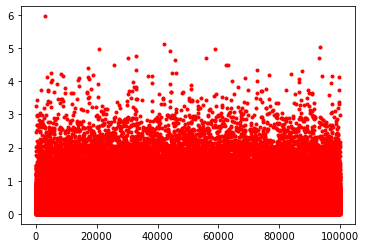

In [32]:
plt.plot(photon_arrival_times,'.r')

In [34]:
3.2**2 / 0.5**2  , 3.2/.5

(40.96000000000001, 6.4)

photon count arrial ========(10000,)
True lifetime: 4 ns
Fitted lifetime: 3.840 ± 0.141 ns
Total photons detected: 9582 why not 10000?????
Coefficient of variation: 3.68%


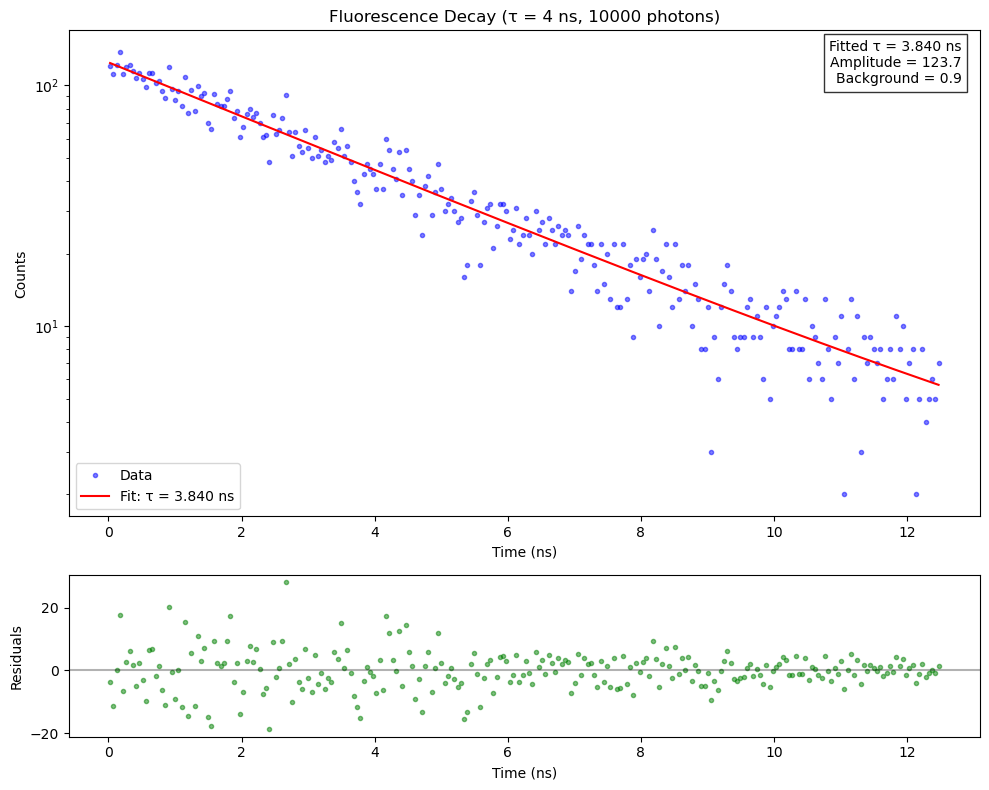

In [92]:


def generate_lifetime_decay_photon_simulation(num_photons, lifetime, 
                                              time_range=(0, 12.5), 
                                              time_bins=256, 
                                             background=0, 
                                             instrument_response=None):
    """
    Simulate a fluorescence lifetime decay curve using direct photon arrival time simulation.
    
    Parameters:
    -----------
    num_photons : int
        Total number of photons to simulate
    lifetime : float
        Fluorescence lifetime (in nanoseconds)
    time_range : tuple
        (min_time, max_time) in nanoseconds
    time_bins : int
        Number of time bins to use
    background : float
        Expected background counts per bin
    instrument_response : array or None
        Instrument response function (probability distribution)
        
    Returns:
    --------
    times : numpy array
        Time points (center of bins) of the simulation
    counts : numpy array
        Photon counts at each time point
    """
    min_time, max_time = time_range
    
    # Simulate individual photon arrival times using exponential distribution
    # Scale parameter in numpy's exponential distribution is the mean (lifetime)
    photon_arrival_times = np.random.exponential(scale=lifetime, size=num_photons)
    print(f"photon count arrial ========{photon_arrival_times.shape}")
    # Filter out photons outside the time range
    photon_arrival_times = photon_arrival_times[photon_arrival_times <= max_time]
    
    # Create the binned histogram (the decay curve)
    bin_edges = np.linspace(min_time, max_time, time_bins + 1)
    counts, _ = np.histogram(photon_arrival_times, bins=bin_edges)
    
    # Calculate the center of each bin for the time axis
    times = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Apply instrument response function if provided
    if instrument_response is not None:
        # Ensure IRF is properly sized and normalized
        if len(instrument_response) != time_bins:
            irf_resized = np.interp(np.linspace(0, 1, time_bins), 
                                   np.linspace(0, 1, len(instrument_response)), 
                                   instrument_response)
            irf_normalized = irf_resized / np.sum(irf_resized)
        else:
            irf_normalized = instrument_response / np.sum(instrument_response)
            
        # Convolve with the IRF
        counts = np.convolve(counts, irf_normalized, mode='same')
    
    # Add random background counts (Poisson distributed)
    if background > 0:
        bg_counts = np.random.poisson(background, size=time_bins)
        counts = counts + bg_counts
    
    return times, counts

def exponential_model(t, a, tau, c):
    """
    Single exponential decay model with background.
    
    Parameters:
    t : time
    a : amplitude
    tau : lifetime
    c : background constant
    """
    return a * np.exp(-t / tau) + c

def fit_lifetime_decay(times, counts, initial_guess=None):
    """
    Fit the lifetime decay curve with a single exponential model.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    initial_guess : tuple or None
        Initial parameters (amplitude, lifetime, background)
        
    Returns:
    --------
    params : tuple
        Fitted parameters (amplitude, lifetime, background)
    covariance : array
        Covariance matrix of the fit
    """
    if initial_guess is None:
        # Estimate initial parameters
        background = np.min(counts)
        amplitude = np.max(counts) - background
        lifetime = times[len(times)//3] - times[0]  # Rough estimate
        initial_guess = (amplitude, lifetime, background)
    
    try:
        params, covariance = curve_fit(exponential_model, times, counts, p0=initial_guess)
        return params, covariance
    except:
        print("Fitting failed. Try adjusting initial parameters.")
        return initial_guess, None

def plot_lifetime_decay(times, counts, fitted_params=None, log_scale=True, 
                        residuals=True, title="Fluorescence Lifetime Decay"):
    """
    Plot the lifetime decay curve and optionally the fit.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    fitted_params : tuple or None
        Fitted parameters (amplitude, lifetime, background)
    log_scale : bool
        Whether to use log scale for y-axis
    residuals : bool
        Whether to plot residuals (only if fitted_params is provided)
    title : str
        Plot title
    """
    if residuals and fitted_params is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                       gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot data
    ax1.plot(times, counts, 'b.', alpha=0.5, label='Data')
    
    # Plot fit if provided
    if fitted_params is not None:
        amplitude, lifetime, background = fitted_params
        fitted_curve = exponential_model(times, amplitude, lifetime, background)
        ax1.plot(times, fitted_curve, 'r-', label=f'Fit: τ = {lifetime:.3f} ns')
        
        # Add fit information to the plot
        text_info = f"Fitted τ = {lifetime:.3f} ns\nAmplitude = {amplitude:.1f}\nBackground = {background:.1f}"
        ax1.text(0.98, 0.98, text_info, transform=ax1.transAxes, 
                 ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel('Counts')
    ax1.set_title(title)
    ax1.legend()
    
    if log_scale:
        ax1.set_yscale('log')
    
    # Plot residuals if requested
    if residuals and fitted_params is not None:
        fitted_curve = exponential_model(times, *fitted_params)
        res = counts - fitted_curve
        ax2.plot(times, res, 'g.', alpha=0.5)
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Time (ns)')
        ax2.set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def simulate_multi_exponential_decay(num_photons, lifetimes, amplitudes, time_range=(0, 10), time_bins=1000, background=0):
    """
    Simulate a multi-exponential fluorescence decay curve.
    
    Parameters:
    -----------
    num_photons : int
        Total number of photons to simulate
    lifetimes : list of float
        Lifetimes in nanoseconds for each component
    amplitudes : list of float
        Relative amplitudes for each component (will be normalized)
    time_range : tuple
        (min_time, max_time) in nanoseconds
    time_bins : int
        Number of time bins to use
    background : float
        Expected background counts per bin
        
    Returns:
    --------
    times : numpy array
        Time points of the simulation
    counts : numpy array
        Photon counts at each time point
    """
    min_time, max_time = time_range
    
    # Normalize amplitudes to sum to 1
    norm_amplitudes = np.array(amplitudes) / np.sum(amplitudes)
    
    # Determine number of photons for each component
    component_photons = np.random.multinomial(num_photons, norm_amplitudes)
    
    # Initialize empty array for all photon arrival times
    all_photon_times = np.array([])
    
    # Generate photons for each lifetime component
    for i, (lifetime, n_photons) in enumerate(zip(lifetimes, component_photons)):
        if n_photons > 0:
            # Generate arrival times for this component
            photon_times = np.random.exponential(scale=lifetime, size=n_photons)
            all_photon_times = np.append(all_photon_times, photon_times)
    
    # Filter out photons outside the time range
    all_photon_times = all_photon_times[all_photon_times <= max_time]
    
    # Create the binned histogram
    bin_edges = np.linspace(min_time, max_time, time_bins + 1)
    counts, _ = np.histogram(all_photon_times, bins=bin_edges)
    
    # Calculate bin centers for time axis
    times = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Add random background counts if specified
    if background > 0:
        bg_counts = np.random.poisson(background, size=time_bins)
        counts = counts + bg_counts
    
    return times, counts

# Example usage
if __name__ == "__main__":
    # Parameters
    num_photons = 10000
    true_lifetime = 4  # nanoseconds
    time_range = (0, 12.5)  # nanoseconds
    time_bins = 256
    background_level = 0 # average background counts per bin
    
    # Simulate decay curve using direct photon simulation
    times, counts = generate_lifetime_decay_photon_simulation(
        num_photons=num_photons,
        lifetime=true_lifetime,
        time_range=time_range,
        time_bins=time_bins,
        background=background_level
    )
    
    # Fit the data
    fitted_params, covariance = fit_lifetime_decay(times, counts)
    
    if covariance is not None:
        # Calculate uncertainty
        perr = np.sqrt(np.diag(covariance))
        fitted_lifetime = fitted_params[1]
        lifetime_error = perr[1]
        cv_percent = (lifetime_error / fitted_lifetime) * 100
        print(f"True lifetime: {true_lifetime} ns")
        print(f"Fitted lifetime: {fitted_params[1]:.3f} ± {perr[1]:.3f} ns")
        print(f"Total photons detected: {np.sum(counts)} why not 10000?????")
        print(f"Coefficient of variation: {cv_percent:.2f}%")
    else:
        print(f"True lifetime: {true_lifetime} ns")
        print(f"Fitting failed to converge")
    
    # Plot the results
    plot_lifetime_decay(times, counts, fitted_params, log_scale=True, residuals=True,
                       title=f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons)")
    '''
    # Example of multi-exponential decay simulation
    print("\nSimulating multi-exponential decay...")
    times_multi, counts_multi = simulate_multi_exponential_decay(
        num_photons=num_photons,
        lifetimes=[1.2, 3.5],  # Two lifetime components
        amplitudes=[0.7, 0.3],  # 70% first component, 30% second component
        time_range=time_range,
        time_bins=time_bins,
        background=background_level
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(times_multi, counts_multi, 'b.', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Time (ns)')
    plt.ylabel('Counts')
    plt.title('Multi-exponential Decay (τ₁=1.2ns, τ₂=3.5ns)')
    plt.tight_layout()
    plt.show()
    '''

In [45]:
bincalc = np.rint(np.linspace(2,256,15)).astype(int)
print(bincalc)

[  2  20  38  56  75  93 111 129 147 165 183 202 220 238 256]


In [ ]:
plot

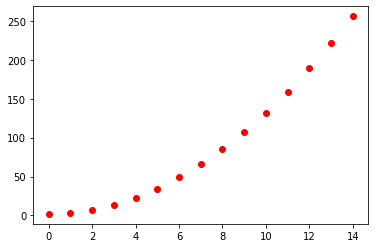

In [13]:
bincalc = np.rint(2 + (256-2) * (np.linspace(0, 1, 15)**2)).astype(int)
plt.plot(bincalc,'or')

In [15]:
len(bincalc)

15

In [20]:
12.5/256, 12.5/4096

(0.048828125, 0.0030517578125)

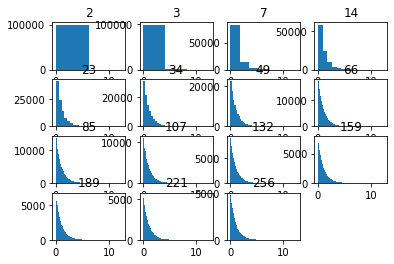

In [16]:

for k in enumerate(bincalc):
    plt.subplot(4,4,k[0]+1)
    plt.hist(photon_arrival_times,bins=k[1])
    plt.title(f'{k[1]}')

In [12]:
np.rint(2 + (256-2) * (np.linspace(0, 1, 15)**2)).astype(int)

array([  2,   3,   7,  14,  23,  34,  49,  66,  85, 107, 132, 159, 189,
       221, 256])

photon count arrial ========(10000,)
Fitting failed. Try adjusting initial parameters.
True lifetime: 1.0 ns
Fitting failed to converge
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 1.020 ± inf ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: inf%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 0.976 ± 0.002 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.25%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 0.976 ± 0.004 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.39%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 1.002 ± 0.008 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.77%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 1.005 ± 0.006 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.56%
photon 

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_36940\3154002414.py:109: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exponential_model, times, counts, p0=initial_guess)


photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.790 ± 0.143 ns
Total photons detected: 9680 why not 10000???
Coefficient of variation: 3.77%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.561 ± 0.109 ns
Total photons detected: 9672 why not 10000???
Coefficient of variation: 3.06%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 4.036 ± 0.152 ns
Total photons detected: 9689 why not 10000???
Coefficient of variation: 3.76%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.653 ± 0.115 ns
Total photons detected: 9676 why not 10000???
Coefficient of variation: 3.15%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.690 ± 0.118 ns
Total photons detected: 9653 why not 10000???
Coefficient of variation: 3.20%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_36940\3154002414.py:79: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau) + c


photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns
Fitted lifetime: 3.420 ± inf ns
Total photons detected: 9770 why not 10000???
Coefficient of variation: inf%
photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns
Fitted lifetime: 3.267 ± 0.076 ns
Total photons detected: 9787 why not 10000???
Coefficient of variation: 2.33%
photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns
Fitted lifetime: 3.126 ± 0.071 ns
Total photons detected: 9794 why not 10000???
Coefficient of variation: 2.28%
photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns
Fitted lifetime: 3.205 ± 0.089 ns
Total photons detected: 9792 why not 10000???
Coefficient of variation: 2.77%
photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns
Fitted lifetime: 3.298 ± 0.064 ns
Total photons detected: 9823 why not 10000???
Coefficient of variation: 1.95%
photon count arrial ========(10000,)
True lifetime: 3.2222222222222223 ns

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_36940\3154002414.py:79: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-t / tau) + c


True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.463 ± 0.005 ns
Total photons detected: 9998 why not 10000???
Coefficient of variation: 0.37%
photon count arrial ========(10000,)
True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.436 ± 0.008 ns
Total photons detected: 9998 why not 10000???
Coefficient of variation: 0.58%
photon count arrial ========(10000,)
True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.429 ± 0.017 ns
Total photons detected: 9999 why not 10000???
Coefficient of variation: 1.19%
photon count arrial ========(10000,)
True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.448 ± 0.008 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.56%
photon count arrial ========(10000,)
True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.466 ± 0.021 ns
Total photons detected: 9998 why not 10000???
Coefficient of variation: 1.43%
photon count arrial ========(10000,)
True lifetime: 1.4444444444444444 ns
Fitted lifetime: 1.447 ± 0.017 n

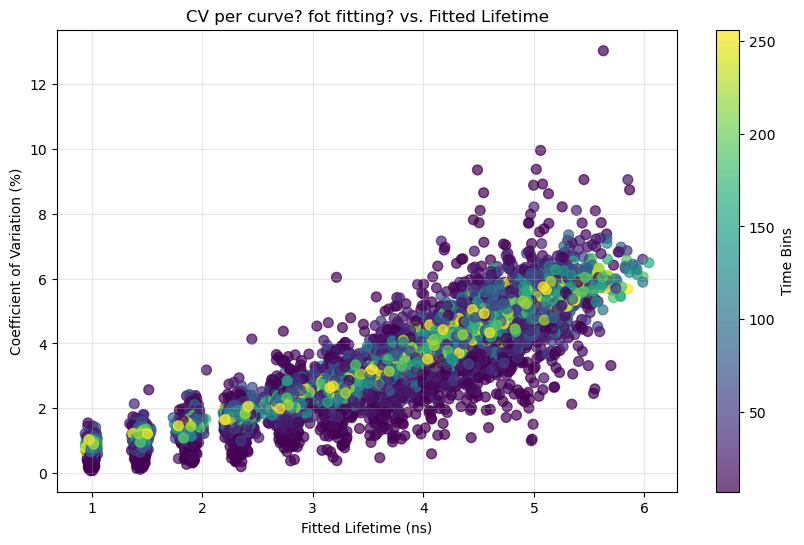

140


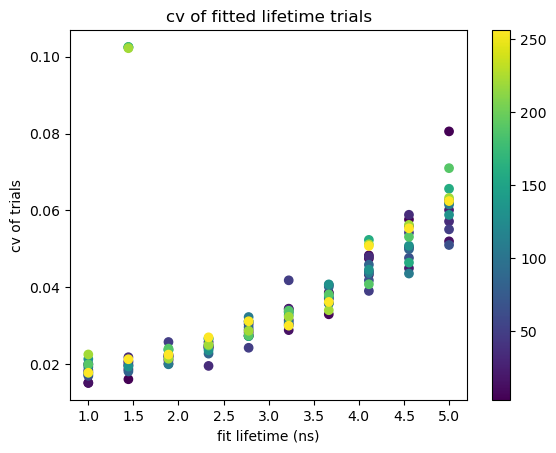

In [93]:
# Example usage

datastore = []

#bincalc = np.rint(np.linspace(2,256,15)).astype(int)

bincalc = np.rint(2 + (256-2) * (np.linspace(0, 1, 15)**2)).astype(int)

trials = np.linspace(1,5,100)

taurepeats = np.linspace(1,5,10)

for c in trials:
    
    for t in taurepeats:
        
        all_data = []
        
        for b in bincalc:
            
        
            # Parameters
            num_photons = 10000
            true_lifetime = t  # nanoseconds
            time_range = (0, 12.5)  # nanoseconds
            time_bins = b
            background_level = 0  # average background counts per bin
            
            # Simulate decay curve using direct photon simulation
            times, counts = generate_lifetime_decay_photon_simulation(
                num_photons=num_photons,
                lifetime=true_lifetime,
                time_range=time_range,
                time_bins=time_bins,
                background=background_level
            )
            
            # Fit the data
            fitted_params, covariance = fit_lifetime_decay(times, counts)
            
            if covariance is not None:
                # Calculate uncertainty
                perr = np.sqrt(np.diag(covariance))
                fitted_lifetime = fitted_params[1]
                lifetime_error = perr[1]
                cv_percent = (lifetime_error / fitted_lifetime) * 100
                print(f"True lifetime: {true_lifetime} ns")
                print(f"Fitted lifetime: {fitted_params[1]:.3f} ± {perr[1]:.3f} ns")
                print(f"Total photons detected: {np.sum(counts)} why not 10000???")
                print(f"Coefficient of variation: {cv_percent:.2f}%")
                datastore.append({"true lifetime": true_lifetime, "fitted lifetime": fitted_lifetime, "time_bins": time_bins, "cv_percent": cv_percent})
            else:
                print(f"True lifetime: {true_lifetime} ns")
                print(f"Fitting failed to converge")
            
            all_data.append({
                'times': times,
                'counts': counts,
                'fitted_params': fitted_params,
                'bin_size': time_bins
            })

            # Plot the results
            #plot_lifetime_decay(times, counts, fitted_params, log_scale=True, residuals=True,
                            #title=f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons, time bin {time_bins})")
        '''    
        plt.figure(figsize=(12, 8))

        # Create a color cycle for different curves
        colors = plt.cm.viridis(np.linspace(0, 1, len(all_data)))

        for i, data in enumerate(all_data):
            times = data['times']
            counts = data['counts']
            fitted_params = data['fitted_params']
            bin_size = data['bin_size']
            
            # Plot data points
            plt.semilogy(times, counts, 'o', label=f'Bin size: {bin_size}', 
                            color=colors[i], markersize=4, alpha=0.7)
            
            # Plot fitted curve if fit was successful
            if fitted_params is not None:
                fitted_curve = exponential_model(times, *fitted_params)
                plt.semilogy(times, fitted_curve, '-', linewidth=2, 
                                color=colors[i], alpha=0.9)

        plt.xlabel('Time (ns)')
        plt.ylabel('Counts (log scale)')
        plt.title(f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        '''

# Extract the data for plotting
fitted_lifetimes = [item["fitted lifetime"] for item in datastore]
cv_percents = [item["cv_percent"] for item in datastore]
bin_sizes = [item["time_bins"] for item in datastore]

from collections import defaultdict
data_by_true_lifetime = defaultdict(list)
for item in datastore:
    true_lifetime = item["true lifetime"]
    fitted = item["fitted lifetime"]
    bin = item["time_bins"]
    data_by_true_lifetime[true_lifetime,bin].append(fitted)

true = []
cvbytrue = []
binbytrue = []

#not sure if this really does what i think it does
#goal to calculate cv for batch of true lifetimes separated by the bin value
numcvcount = 0
for key, fitted in data_by_true_lifetime.items():
    true_lifetime,bin = key
    mean_fittedbytrue = np.mean(fitted)
    std_fittedbytrue = np.std(fitted)
    cvbytruecalc = (std_fittedbytrue / mean_fittedbytrue)
    #print(len(fitted))
    true.append(true_lifetime)
    cvbytrue.append(cvbytruecalc)
    binbytrue.append(bin)

    numcvcount += 1


plt.figure(figsize=(10, 6))
scatter = plt.scatter(fitted_lifetimes, cv_percents, 
                     c=bin_sizes,        # Color points by bin size
                     s=50,              # Base point size
                     alpha=0.7,         # Add transparency
                     cmap='viridis')    # Color map

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Time Bins')

plt.xlabel('Fitted Lifetime (ns)')
plt.ylabel('Coefficient of Variation (%)')
plt.title('CV per curve? fot fitting? vs. Fitted Lifetime')
plt.grid(True, alpha=0.3)
plt.show()

plt.scatter(true,cvbytrue, c=binbytrue)
cbar.set_label('time bins')
plt.colorbar()
plt.xlabel('fit lifetime (ns)')
plt.ylabel('cv of trials')
plt.title('cv of fitted lifetime trials')
plt.show


print(numcvcount)

In [82]:
print(f"Total unique (true lifetime, bin) pairs: {len(data_by_true_lifetime)}")


Total unique (true lifetime, bin) pairs: 140
